In [1]:
import torch
import os
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
#GPU_CUDA Details 
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
print(torch.device("cuda"))

True
True
cuda


In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])
img_dir='cell_images/';
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2
test_size = 0.1
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

#print(len(valid_idx), len(test_idx), len(train_idx))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

In [5]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
#Optimizer & loss Func #loss_func = torch.nn.MSELoss()
use_cuda=torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(net_Adam.parameters(), lr = LR, betas= (0.9, 0.99))
#torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#optimizer=torch.optim.RMSprop(model.parameters(), lr = LR, alpha = 0.9)

In [7]:
# import EarlyStopping
from pytorchtool import EarlyStopping

In [11]:
    patience=20
    n_epochs=2
#train_model(n_epochs, model, optimizer, loss_func, use_cuda,patience)
#def train_model(n_epochs, model, optimizer, loss_func, use_cuda,patience):
    
        
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []    
    
     # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True) 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        #train_losses = 0.0
        #valid_losses = 0.0
        
        
        # train the model #        
        model.train()
        for batch, (data, target) in enumerate(train_loader,1):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()            
            output = model(data)            
            # calculate loss
            loss = loss_func(output, target)            
            # back prop
            loss.backward()            
            # grad
            optimizer.step()            
            #train_losses = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_losses))
            # record training loss
            train_losses.append(loss.item())
            
            """if batch_idx % 100 == 0:"""
            #print('Epoch %d, Batch %d loss: %.6f' %(epoch, batch + 1, train_losses))        
           
        # validate the model
        
        model.eval()
        for data, target in valid_loader:
            # move to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = loss_func(output, target)
            #valid_losses = valid_losses + ((1 / (batch_idx + 1)) * (loss.data - valid_losses))
            valid_losses.append(loss.item())            
        
        # print training/validation statistics 
       # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        epoch_len = len(str(n_epochs))
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss,valid_loss ))
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)        
        if early_stopping.early_stop:
            print("Early stopping")
            break   
            
       
            
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))      
            
    #return model

Train Loss: 0.3636045202810243
Valid_Loss: 0.4565687221771031
Epoch: 1 	Training Loss: 0.363605 	Validation Loss: 0.456569
Validation loss decreased (inf --> 0.456569).  Saving model ...
Train Loss: 0.3692916091901577
Valid_Loss: 0.344699022139428
Epoch: 2 	Training Loss: 0.369292 	Validation Loss: 0.344699
Validation loss decreased (0.456569 --> 0.344699).  Saving model ...


In [12]:
"""patience=20
n_epochs=2
train_model(n_epochs, model, optimizer, loss_func, use_cuda,patience)
"""

'patience=20\nn_epochs=2\ntrain_model(n_epochs, model, optimizer, loss_func, use_cuda,patience)\n'

In [18]:
print("Train Loss:",train_loss)
print("Valid_Loss:",valid_loss)
#print(ea)

Train Loss: 0.3692916091901577
Valid_Loss: 0.344699022139428


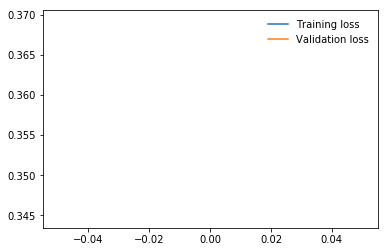

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [21]:
import matplotlib.pyplot as plt
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

TypeError: object of type 'numpy.float64' has no len()

<Figure size 720x576 with 0 Axes>

In [22]:
model.load_state_dict(torch.load('malaria_detection.pt'))

In [23]:
def test(model, loss_func, use_cuda):

    # monitor test loss and accuracy
    test_losses = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_func(output, target)
        # update average test loss 
        test_losses = test_losses + ((1 / (batch_idx + 1)) * (loss.data - test_losses))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test_losses: {:.6f}\n'.format(test_losses))
    print(test_losses)

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
test(model, loss_func, use_cuda)


Test_losses: 0.360145

tensor(0.3601, device='cuda:0')

Test Accuracy: 84% (2332/2756)


In [ ]:
# visualize the loss as the network trained
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1),valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:

def load_input_image(img_path):
    image = Image.open(img_path)
    
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image
#load_input_image()

In [ ]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [ ]:
from glob import glob
from PIL import Image
from termcolor import colored

inf = np.array(glob("../cell_images/Parasitized/*"))
uninf = np.array(glob("../cell_images/Uninfected/*"))

for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()